<a href="https://colab.research.google.com/github/bzhao10/CourseProject/blob/main/Code/Course_project_410_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install jsonlines

In [39]:
import os
import jsonlines
import csv
import pandas as pd
import random

#The following method is used to create readable traindata in csv format

data = []

#Convert 'SARCASM' label in train.jsonl into 0 and 1 
with open("train.jsonl","r+",encoding='utf-8') as f:
    for item in jsonlines.Reader(f):
        if item['label'] == 'SARCASM':
            item['label'] = 0
        else:
            item['label'] = 1
        data.append(item)

#Remove '@USER' and '<URL>' content and parse the train.jsonl data into csv format
with open('traindata.csv', 'w+', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_head = ['context', 'response', 'label']
    csv_writer.writerow(csv_head)
 
    for i in range(len(data)):
        data_row = [(''.join(data[i]['context'])).replace('@USER', '').replace('<URL>',''),
                    (data[i]['response']).replace('@USER', '').replace('<URL>',''), data[i]['label']]
        csv_writer.writerow(data_row)

    total = pd.read_csv("traindata.csv")

In [40]:
#The following method is used to create readable testdata in csv format
data = []

with open('test.jsonl',"r+",encoding='utf-8') as f:
    for item in jsonlines.Reader(f):
        data.append(item)

#Remove '@USER' and '<URL>' content and parse the train.jsonl data into csv format
with open('testdata.csv', 'w+', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_head = ['context', 'response', 'id']
    csv_writer.writerow(csv_head)

    for i in range(len(data)):
        data_row = [(''.join(data[i]['context'])).replace('@USER', '').replace('<URL>', ''),
                    (data[i]['response']).replace('@USER', '').replace('<URL>', ''), data[i]['id']]
        csv_writer.writerow(data_row)

total = pd.read_csv("testdata.csv")

In [41]:
!pip install transformers==3.5.1

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer, RobertaTokenizerFast, AlbertTokenizer

# specify CPU as our device, since our Code will exceed Google Colab GPU RAM limitation
device = torch.device("cpu")

In [43]:
# Create the train text entry in reponse + context format, 
# Based on our paper research, this combination is the best fit for the twitter text classification
df = pd.read_csv("traindata.csv")
df['text'] = df['response']+df['context']
df.head() # Check the first 5 entries in the traindata.csv file

,context,response,label,text
0,A minor child deserves privacy and should be k...,I don't get this .. obviously you do care o...,0,I don't get this .. obviously you do care o...
1,Why is he a loser ? He's just a Press Secret...,trying to protest about . Talking about him ...,0,trying to protest about . Talking about him ...
2,Donald J . Trump is guilty as charged . The ev...,He makes an insane about of money from the ...,0,He makes an insane about of money from the ...
3,Jamie Raskin tanked Doug Collins . Collins loo...,Meanwhile Trump won't even release his SAT s...,0,Meanwhile Trump won't even release his SAT s...
4,Man ... y ’ all gone “ both sides ” the apocal...,Pretty Sure the Anti-Lincoln Crowd Claimed T...,0,Pretty Sure the Anti-Lincoln Crowd Claimed T...


In [44]:
# Create the test text entry in reponse + context format, 
# Based on our paper research, this combination is the best fit for the twitter text classification
td = pd.read_csv("testdata.csv")
td['text'] = td['context']+td['response'] 
td.head() # Check the first 5 entries in the testdata.csv file

,context,response,id,text
0,Well now that ’ s problematic AF My 5 year o...,"My 3 year old , that just finished reading ...",twitter_1,Well now that ’ s problematic AF My 5 year o...
1,Last week the Fake News said that a section of...,How many verifiable lies has he told now ? 1...,twitter_2,Last week the Fake News said that a section of...
2,Let ’ s Aplaud Brett When he deserves it he c...,Maybe Docs just a scrub of a coach ... I me...,twitter_3,Let ’ s Aplaud Brett When he deserves it he c...
3,Women generally hate this president . What's u...,is just a cover up for the real hate inside ...,twitter_4,Women generally hate this president . What's u...
4,"Dear media Remoaners , you excitedly sharing c...",The irony being that he even has to ask why .,twitter_5,"Dear media Remoaners , you excitedly sharing c..."


In [45]:
# Separate the traindata.csv into train and validation dataset
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# Create test dataset to generate the answer.txt file from best model
test_text = td['text']    

In [46]:
# import RoBERTa pretrained model from transformer
roberta = AutoModel.from_pretrained('roberta-base')


# Load the RoBERTa tokenizer from transformer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [47]:
# Initialize the send_id
text = ["this is a Roberta model tutorial", "we will fine-tune a Roberta model"]
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [48]:
print(sent_id)

{'input_ids': [[0, 9226, 16, 10, 1738, 102, 1421, 35950, 2, 1, 1, 1], [0, 1694, 40, 2051, 12, 90, 4438, 10, 1738, 102, 1421, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


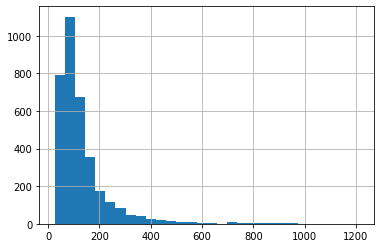

In [49]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [50]:
#Initialize the max sequence length
max_seq_len = 200

In [51]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [52]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [53]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
 
# define a batch size
batch_size = 31

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [54]:
# freeze all the parameters
for param in roberta.parameters():
    param.requires_grad = False

In [55]:
class RoBERTa_Arch(nn.Module):

    def __init__(self, roberta):
      
      super(RoBERTa_Arch, self).__init__()

      self.roberta = roberta 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.roberta(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [56]:
# pass the pre-trained RoBERTa to our define architecture
model = RoBERTa_Arch(roberta)

# push the model to CPU
model = model.to(device)

In [57]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [58]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [59]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [60]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [61]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [62]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()                          
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss                                                    
        torch.save(model.state_dict(), 'saved_weights.pt')  
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.697
Validation Loss: 0.686

 Epoch 2 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.687
Validation Loss: 0.674

 Epoch 3 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.669
Validation Loss: 0.651

 Epoch 4 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.640
Validation Loss: 0.610

 Epoch 5 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.599
Validation Loss: 0.574

 Epoch 6 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.580
Validation Loss: 0.625

 Epoch 7 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.565

 Epoch 8 / 10
  Batch    50  of    113.
  Batch   100  of    113.

Evaluating...

Training Loss: 0.574
Validat

In [63]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [64]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)

In [ ]:
print(preds)

In [66]:
import csv
import pandas as pd

predresult =[]

for item in preds:
  if item == 1:
    item = 'NOT_SARCASM'
  else:
    item = 'SARCASM'
  predresult.append(item)

with open ('testdata.csv') as f:
  reader = csv.reader(f)
  column = [row[2] for row in reader]

#create test answer csv document
with open ('testans.csv', 'w+', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)

    for i in range(len(predresult)):
      data_row = [column[i+1],predresult[i]]
      csv_writer.writerow(data_row)

#convert csv to txt
output = open ('answer.txt','w')
with open('testans.csv', encoding='utf-8') as f:
    for row in f:
      output.write(row)